In [1]:

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime


In [2]:

#it will be nice to write a function  to convert this dates into date time since the data contain dates
def convert_date(date_str):
    try:
        return datetime.strptime(date_str, "%d%b%Y")
    except ValueError:
        return None  # Handle any potential errors by returning None






In [3]:
# Loading data and using delimiter to seperate the data nicely
defaults_df = pd.read_csv('defaults.csv', delimiter=';')
exchangerates_df = pd.read_csv('exchangerates.csv', delimiter=';')




In [4]:
# Apply the cover_date function on the dates column
defaults_df['DefaultDate'] = defaults_df['DefaultDate'].apply(convert_date)
defaults_df['DefaultEndDate'] = defaults_df['DefaultEndDate'].apply(convert_date)

exchangerates_df['ReportDate'] = exchangerates_df['ReportDate'].apply(convert_date)


In [5]:

print("Defaults Dataset:")
display(defaults_df.head(7))

print("\nExchange Rates Dataset:")
display(exchangerates_df.head())



Defaults Dataset:


,AgreementGenId,DefaultDate,DefaultEndDate,DefaultRankNum,DefaultTypeCd,ValutaKod,LossAmount,EAD
0,1180176,2010-05-01,2018-02-28 00:00:00,26,D90,SEK,5097.970135,14980.383
1,1196292,2006-11-01,2018-05-31 00:00:00,20,HAF,SEK,28663.800000,28663.800
2,1211676,2008-05-01,2008-09-30 00:00:00,26,D90,SEK,16674.493000,16674.493
3,1226304,2019-04-01,2999-12-31 00:00:00,26,D90,SEK,10293.008000,10293.008
4,1235808,2010-11-01,2018-10-31 00:00:00,26,D90,SEK,22431.816000,22431.816
5,1257420,2018-04-01,2999-12-31 00:00:00,26,D90,SEK,3664.859000,3664.859
6,1270512,2006-05-01,2018-10-31 00:00:00,20,HAF,SEK,11006.809000,11006.809



Exchange Rates Dataset:


,Currency,CurrencyCd,ReportDate,Valuation
0,United Kingdom Pound,gbp,2014-08-07,11.61883
1,United Kingdom Pound,gbp,2012-01-10,10.65730
2,Australian Dollar,aud,2020-07-09,6.59509
3,Australian Dollar,aud,2009-04-08,5.82534
4,Danish Krone,dkk,2018-05-01,1.40921


# Explore both data

A careful instrospect at the data shows credit risk data between financial institution and client (borrower defaults on loan)

On the default.csv file,  the data shows SEK is the base currency and 
majority of the currencies in the Valutakod are SEK in the default data but other currencies exist

In [6]:
# show rows in defaults_df where ValutaKod is not equal to "SEK"
non_sek_rows = defaults_df[defaults_df['ValutaKod'] != "SEK"]
non_sek_rows.head()


,AgreementGenId,DefaultDate,DefaultEndDate,DefaultRankNum,DefaultTypeCd,ValutaKod,LossAmount,EAD
29,1329252,2018-04-01,2999-12-31 00:00:00,26,D90,NOK,22856.801,22856.801
30,1334976,2014-11-01,2999-12-31 00:00:00,20,HAF,USD,10118.009,10118.009
46,1416924,2014-09-01,2016-02-29 00:00:00,26,D90,EUR,19004.172,19004.172
67,1557036,2012-03-01,2999-12-31 00:00:00,20,HAF,NOK,21415.405,21415.405
74,1583400,2009-01-01,2010-03-31 00:00:00,11,SS,USD,10972.555,10972.555


In [7]:
# show unique values in ValutaKod and CurrencyCd in the exchange  and default data to examine
unique_valutakod = defaults_df['ValutaKod'].unique()
unique_currencycd = exchangerates_df['CurrencyCd'].unique()

unique_valutakod, unique_currencycd

(array(['SEK', 'NOK', 'USD', 'EUR'], dtype=object),
 array(['gbp', 'aud', 'dkk', 'eur', 'usd', 'nok'], dtype=object))

In [8]:
# it will be nice to apply uppercase for matching purpose
defaults_df['ValutaKod'] = defaults_df['ValutaKod'].str.upper()
exchangerates_df['CurrencyCd'] = exchangerates_df['CurrencyCd'].str.upper()

In [9]:
# Initialize SQLite connection
conn = sqlite3.connect(":memory:")
defaults_df.to_sql("defaults", conn, index=False, if_exists="replace")
exchangerates_df.to_sql("exchangerates", conn, index=False, if_exists="replace")


# Question 1: How many distinct defaults are in the dataset defaults?

In [10]:
query = """
SELECT COUNT(DISTINCT AgreementGenId) AS distinct_defaults_count
FROM defaults
"""

# Execute
distinct_defaults_count = pd.read_sql(query, conn)
print("Number of distinct defaults:")
display(distinct_defaults_count)

Number of distinct defaults:


,distinct_defaults_count
0,623


This show that there are 623 unique clients loan agreements default

# Question 2, Make a distribution graph of how many times agreements default.

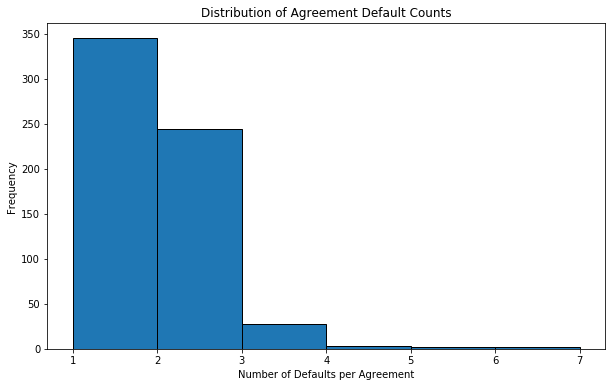

In [11]:

#count each AgreementGenId
query_distribution = """
SELECT AgreementGenId, COUNT(*) AS default_count
FROM defaults
GROUP BY AgreementGenId
"""

default_counts_df = pd.read_sql(query_distribution, conn)

# Plot
plt.figure(figsize=(10, 6))
plt.hist(default_counts_df['default_count'], bins=range(1, default_counts_df['default_count'].max() + 2), edgecolor='black')
plt.title("Distribution of Agreement Default Counts")
plt.xlabel("Number of Defaults per Agreement")
plt.ylabel("Frequency")
plt.show()


This shows most loan agreemnet defaults once or twice

# Question 3

Perform 9 month aggregation on default data with the following rules for other variables:

a.
The EAD and loss amount come from the first default.


b.
The DefaultTypeCd must be the riskiest one. The riskiest default is the one with the lowest ranking number

In [12]:
# SQL query for 9-month aggregation of defaults data
aggregation_query = """
WITH OrderedDefaults AS (
    SELECT
        AgreementGenId,
        DefaultDate,
        DefaultEndDate,
        DefaultRankNum,
        DefaultTypeCd,
        ValutaKod,
        LossAmount,
        EAD,
        LEAD(DefaultDate) OVER (PARTITION BY AgreementGenId ORDER BY DefaultDate) AS NextDefaultDate
    FROM defaults
),
MergedDefaults AS (
    SELECT
        AgreementGenId,
        MIN(DefaultDate) AS FirstDefaultDate,
        MAX(DefaultEndDate) AS LastDefaultEndDate,
        MIN(DefaultRankNum) AS RiskiestRankNum,
        FIRST_VALUE(DefaultTypeCd) OVER (PARTITION BY AgreementGenId ORDER BY DefaultRankNum ASC) AS RiskiestTypeCd,
        FIRST_VALUE(LossAmount) OVER (PARTITION BY AgreementGenId ORDER BY DefaultDate) AS FirstLossAmount,
        FIRST_VALUE(EAD) OVER (PARTITION BY AgreementGenId ORDER BY DefaultDate) AS FirstEAD,
        ValutaKod
    FROM OrderedDefaults
    WHERE julianday(NextDefaultDate) - julianday(DefaultEndDate) <= 273 OR NextDefaultDate IS NULL
    GROUP BY AgreementGenId, DefaultDate
)

SELECT
    AgreementGenId,
    FirstDefaultDate AS DefaultDate,
    LastDefaultEndDate AS DefaultEndDate,
    RiskiestRankNum AS DefaultRankNum,
    RiskiestTypeCd AS DefaultTypeCd,
    ValutaKod,
    FirstLossAmount AS LossAmount,
    FirstEAD AS EAD
FROM MergedDefaults;
"""

# Execute
merged_defaults_df = pd.read_sql_query(aggregation_query, conn)



In [13]:
# Display the resulting merged data
merged_defaults_df.head() 

# Optionally, save to a CSV file if you want to export the results
merged_defaults_df.to_csv("C:\\Users\\Stephen\\Desktop\\Doyenify\\SWEDBANK_Task\\merged_defaults.csv", index=False)


In [14]:
merged_defaults_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AgreementGenId  943 non-null    int64  
 1   DefaultDate     943 non-null    object 
 2   DefaultEndDate  943 non-null    object 
 3   DefaultRankNum  943 non-null    int64  
 4   DefaultTypeCd   943 non-null    object 
 5   ValutaKod       943 non-null    object 
 6   LossAmount      943 non-null    float64
 7   EAD             943 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 59.1+ KB


# Question 4. What is the new number of unique defaults?

In [15]:
# Calculate the new number of unique defaults after aggregation
unique_defaults_count = merged_defaults_df[['AgreementGenId', 'DefaultDate']].drop_duplicates().shape[0]

print(f"New number of unique defaults after nine-month aggregation: {unique_defaults_count}")


New number of unique defaults after nine-month aggregation: 943


# QUESTION 5

Analyse EAD-s and loss amounts


Having found out that some EAD amount exist in other  currencies like USD, Euro and Pounds in the default,

It is adviable to convert it to the base currency SEK using the exchange rate. This will require converting the data
on those currecny that are not SEK in the default data by taking  the taking the excahnge rate on the exact or close date in the exchange rate data

In [16]:
# SQL query to join defaults with the nearest available exchange rate and matching currency code
conversion_query = """
WITH NearestRates AS (
    SELECT
        d.AgreementGenId,
        d.DefaultDate,
        d.DefaultEndDate,
        d.DefaultRankNum,
        d.DefaultTypeCd,
        d.ValutaKod,
        d.LossAmount,
        d.EAD,
        e.CurrencyCd,
        e.ReportDate,
        e.Valuation AS SEK_ExchangeRate,
        MAX(e.ReportDate) OVER (PARTITION BY d.AgreementGenId, d.ValutaKod
                                ORDER BY e.ReportDate DESC
                                RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS NearestReportDate
    FROM defaults d
    LEFT JOIN exchangerates e
    ON d.ValutaKod = e.CurrencyCd AND e.ReportDate <= d.DefaultDate
),
FilteredRates AS (
    SELECT *
    FROM NearestRates
    WHERE ReportDate = NearestReportDate
)
SELECT
    AgreementGenId,
    DefaultDate,
    DefaultEndDate,
    DefaultRankNum,
    DefaultTypeCd,
    ValutaKod,
    LossAmount * SEK_ExchangeRate AS LossAmount_SEK,
    EAD * SEK_ExchangeRate AS EAD_SEK
FROM FilteredRates
WHERE SEK_ExchangeRate IS NOT NULL;
"""

# Execute
converted_defaults_df = pd.read_sql_query(conversion_query, conn)

converted_defaults_df.head()


,AgreementGenId,DefaultDate,DefaultEndDate,DefaultRankNum,DefaultTypeCd,ValutaKod,LossAmount_SEK,EAD_SEK
0,1329252,2018-04-01 00:00:00,2999-12-31 00:00:00,26,D90,NOK,24259.522877,24259.522877
1,1334976,2014-11-01 00:00:00,2999-12-31 00:00:00,20,HAF,USD,74581.867941,74581.867941
2,1416924,2014-09-01 00:00:00,2016-02-29 00:00:00,26,D90,EUR,174656.512474,174656.512474
3,1557036,2012-03-01 00:00:00,2999-12-31 00:00:00,20,HAF,NOK,24771.841426,24771.841426
4,1583400,2009-01-01 00:00:00,2010-03-31 00:00:00,11,SS,USD,84838.149377,84838.149377


In [17]:
converted_defaults_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AgreementGenId  38 non-null     int64  
 1   DefaultDate     38 non-null     object 
 2   DefaultEndDate  38 non-null     object 
 3   DefaultRankNum  38 non-null     int64  
 4   DefaultTypeCd   38 non-null     object 
 5   ValutaKod       38 non-null     object 
 6   LossAmount_SEK  38 non-null     float64
 7   EAD_SEK         38 non-null     float64
dtypes: float64(2), int64(2), object(4)
memory usage: 2.5+ KB


for consistency, it is nice to Update defaults_df with the SEK values from converted_defaults_df

In [18]:

# Set ValutaKod 'SEK' for the rows being updated
defaults_df.loc[defaults_df['AgreementGenId'].isin(converted_defaults_df['AgreementGenId']), 'ValutaKod'] = 'SEK'

# update the LossAmount and EAD columns with the new converted values from converted_defaults_df
defaults_df.update(converted_defaults_df.set_index('AgreementGenId')[['LossAmount_SEK', 'EAD_SEK']].rename(
    columns={'LossAmount_SEK': 'LossAmount', 'EAD_SEK': 'EAD'}))

defaults_df.head()


,AgreementGenId,DefaultDate,DefaultEndDate,DefaultRankNum,DefaultTypeCd,ValutaKod,LossAmount,EAD
0,1180176,2010-05-01,2018-02-28 00:00:00,26,D90,SEK,5097.970135,14980.383
1,1196292,2006-11-01,2018-05-31 00:00:00,20,HAF,SEK,28663.800000,28663.800
2,1211676,2008-05-01,2008-09-30 00:00:00,26,D90,SEK,16674.493000,16674.493
3,1226304,2019-04-01,2999-12-31 00:00:00,26,D90,SEK,10293.008000,10293.008
4,1235808,2010-11-01,2018-10-31 00:00:00,26,D90,SEK,22431.816000,22431.816


In [19]:
# checking if ValutaKod still equal to "SEK"
Check_non_sek_rows = defaults_df[defaults_df['ValutaKod'] != "SEK"]

Check_non_sek_rows.head()


,AgreementGenId,DefaultDate,DefaultEndDate,DefaultRankNum,DefaultTypeCd,ValutaKod,LossAmount,EAD


In [20]:
# Aggregate analysis: total and average EAD and LossAmount in SEK
total_aggregates = defaults_df[['LossAmount', 'EAD']].sum()
average_aggregates = defaults_df[['LossAmount', 'EAD']].mean()


total_aggregates, average_aggregates

(LossAmount    7.159762e+06
 EAD           1.297614e+07
 dtype: float64,
 LossAmount     7552.491533
 EAD           13687.907004
 dtype: float64)

From this insight, i would say the total loss amount is 7,159,762  SEK with
a sum average of 75552  while exposure to default amount to 12,976,140 SEK  averaging 13,687.
This show the average exposure of default by the bank from the borrower is less than the average loss amount

# Question 6

Make a new binary variable that shows if the default is open now. How many defaults are closed and how many are open?




To understand which default is open or close, I will be Employ binary classification
by using the lamba function without the need of creating a function to check the DefaultEndDate column,  and append 1 
if the DefaultEndDate(Date when default status ended) is greater than the current date and  Zero if other

In [21]:

# Define the current date for comparison
current_date = datetime.now()


# Create a binary 'IsOpen' column: 1 if the default is open, 0 if closed
defaults_df['IsOpen'] = defaults_df['DefaultEndDate'].apply(
    lambda end_date: 1 if pd.isnull(end_date) or end_date > current_date else 0
)

# Count and sum
open_defaults = defaults_df['IsOpen'].sum()
closed_defaults = len(defaults_df) - open_defaults


In [22]:
print(f"Number of open defaults: {open_defaults}")
print(f"Number of closed defaults: {closed_defaults}")

Number of open defaults: 85
Number of closed defaults: 863


This show  a current 863 loan default opening with 85 closed

# Question 7

Add 1.6% of EAD to each loss amount. Find the sum of new loss amount and old.
Also calculate the loss percentages on total level and on default type level with the new loss amount.

In [23]:
# adding 1.6% of EAD to the original LossAmount
defaults_df['NewLossAmount'] = defaults_df['LossAmount'] + (0.016 * defaults_df['EAD'])


In [24]:
# Calculate the sum
total_old_loss_sum = defaults_df['LossAmount'].sum()
total_new_loss_sum = defaults_df['NewLossAmount'].sum()

print(f"Total of old loss amounts: {total_old_loss_sum}")
print(f"Total of new loss amounts: {total_new_loss_sum}")


Total of old loss amounts: 7159761.973653771
Total of new loss amounts: 7367380.147092355


Once the new and old toal loss amount is known, the change in percentage will be calcluted
and also the groupby function will be use to explore the percentage change in respective default  type code

In [25]:

# Total level loss percentage to the the new loss amount

total_loss_percentage = ((total_new_loss_sum -total_old_loss_sum)/ total_old_loss_sum)* 100

total_loss_percentage

2.899791560146415

In [26]:
# Default type level loss percentages
type_level_loss_percentages = defaults_df.groupby('DefaultTypeCd').apply(
    lambda x: (x['NewLossAmount'].sum() / x['LossAmount'].sum()) * 100 if x['LossAmount'].sum() != 0 else 0
).reset_index(name='LossPercentage')

print(f"Total loss percentage: {total_loss_percentage}%")
print("Loss percentages by DefaultTypeCd:")
print(type_level_loss_percentages)

Total loss percentage: 2.899791560146415%
Loss percentages by DefaultTypeCd:
  DefaultTypeCd  LossPercentage
0           CON      103.982238
1           D90      102.224212
2           HAF      101.652663
3            KK      102.397843
4         RFF99        0.000000
5            SS      105.873430


This actually show that if each Loss amount increase by 1.6% of their respective EAD,
the percentage of total loss will increase by 2.9% and respective Defaulttype CD will increase by over 100%

# Question 8

A detailed introspect of the data shows credit risk data between a financial institution
and clients (borrower defaults on loan). The data show the default start date of respective client
and date when the default status will end with the exchange rate value at reported dates.

The data contain Exposure at Default (EAD) metric amount the financial organization is exposed to for loan
lending and the total loss amount per respective client represented with agreementIDs. This information can help build a credit risk model that can help banks better predict and prepare for potential losses.

In-depth analysis of the data shows 623 unique clients and most clients defaulted once or twice. It is discovered that there seems to be an increase
in the Loss amount compared to the EAD amount with majority loan default opening. 
It is also discovered that if the Loss amount increases by 1.6% of the EAD metric amount,
the percentage change in the loss amount will be 2.9%, and the defaultype level will increase tremendously 
